In [1]:
import re
import json

def compile(source, defines=""):
    if defines != "":
        !bash -lc "cd .. && rm build/{source}.bench"
    !bash -lc "cd .. && make -s build/{source}.bench EXTRA_CXXFLAGS='{defines}'"
    
def bench(source, n, defines="", t=2**25, l=64):
    compile(source, defines)
    res = !./../build/{source}.bench {n} {t} {l}
    # print(res)
    return float(str(res).split()[1])

def perf(source, n, t):

    PERF_EVENTS = {
        "cycles",
        "instructions",
        "L1-dcache-loads",
        "L1-dcache-load-misses",
        "LLC-loads",
        "LLC-load-misses",
        "cache-references",
        "cache-misses",
    }
    
    compile(source)
    lines = !bash -lc "taskset -c 8 perf stat -r 10 -e cycles,instructions,L1-dcache-loads,L1-dcache-load-misses,LLC-loads,LLC-load-misses,cache-references,cache-misses ./../build/{source}.bench {n} {t}"
    
    data = {}
    for line in lines:
        line = line.split("#", 1)[0]
        m = re.match(r"\s*([\d,]+)\s+([\w\-]+)", line)
        if not m:
            continue

        value = int(m.group(1).replace(",", ""))
        event = m.group(2)

        if event in PERF_EVENTS:
            data[event] = value
    
    return data

In [2]:
perf("matmul12_avx512", 1024, t=2**30)

{'cycles': 1630269570,
 'instructions': 4511738930,
 'L1-dcache-loads': 1900880210,
 'L1-dcache-load-misses': 471501401,
 'cache-references': 1204748177,
 'cache-misses': 4479684}

In [2]:
bench("matmul12_avx512", 1024, t=2**30)

205634210.0

In [4]:
ns = [i for i in range(8, 1024+1, 8)]

In [5]:
names = {
    'matmul1_ikj': 'naive',
    'matmul6_restrict': 'restrict',
    'matmul7_transpose': 'transpose',
    'matmul8_L1_tiles': 'L1_tiles',
    'matmul9_L2_tiles': 'L2_tiles',
    'matmul10_sse': 'sse',
    'matmul11_avx': 'avx',
    'matmul12_avx512': 'avx512',
    'matmul14_kernel': 'kernel', 
}

# results = {name: [bench(source, n) for n in ns] for source, name in names.items()}

# print(results)

In [3]:
import matplotlib.pyplot as plt

    
def plot(results, ns, subset):

    def gflops(l):
        return [n**3 / t / 10**9 for t, n in zip(l, ns)]
    
    plt.figure(figsize=(10,6))
    for label in subset:
        plt.plot(ns, gflops(results[label]), marker='o', linewidth=1, markersize=3, label=label)

    plt.xlabel('n')
    plt.ylabel('GFLOPS')
    plt.ylim(bottom=0)
    plt.margins(0)

    plt.legend()
    
    plt.show()

    
# plot(results, ns, [
# 'naive', 'restrict', 'transpose', 'L1_tiles', 'L2_tiles', 'sse', 'avx', 'avx512', 'kernel'
# ])

In [ ]:
def find_opt_kernel():
    results = {}
    names = []

    ns = [5, 25, 125]
    for n in range(255, 513, 25):
        ns.append(n)
    ns.append(1024)
    ns.append(1500)
    ns.append(2000)
    ns.append(2500)
    
    for rows in range(6, 10+1, 2):
        for cols in range(2, 4+1):
            print("rows:", rows, "cols:", cols)
            name = f"{rows} {cols}"
            result = [bench("matmul18_kernel", n, defines=f"-DKERNEL_R={rows} -DKERNEL_C={cols}") for n in ns]
            print(result)
            results[name] = result
            names.append(name)

    return (results, ns, names)
    # print(results, name)
    # plot(results, ns, names)
results, ns, names = find_opt_kernel()

rows: 6 cols: 2
rm: cannot remove 'build/matmul18_kernel.bench': No such file or directory
[8372.0, 9227.0, 121358.0, 915568.0, 1271459.0, 1633651.0, 2129695.0, 2687678.0, 3145660.0, 3777121.0, 4659891.0, 5301757.0, 5923959.0, 7069095.0, 60615176.0, 190725824.0, 445748768.0, 962964886.0]
rows: 6 cols: 3
[8286.0, 9883.0, 124647.0, 973377.0, 1142754.0, 1580736.0, 1943162.0, 2641564.0, 2774514.0, 3749281.0, 3862722.0, 4993594.0, 5280128.0, 6799379.0, 55065435.0, 175539359.0, 421906967.0, 934637464.0]
rows: 6 cols: 4
[7632.0, 10651.0, 111763.0, 841492.0, 1271338.0, 1493871.0, 2033629.0, 2410950.0, 2721279.0, 3740807.0, 4031886.0, 5124929.0, 5761795.0, 6403479.0, 52349524.0, 174017253.0, 406821031.0, 871355291.0]
rows: 8 cols: 2


In [ ]:
plot(results, ns, names)

In [5]:
def plot_flops(sources, ns):
    results = {}
    for source in sources:
        results[source] = [bench(source, n) for n in ns]
    plot(results, ns, sources)

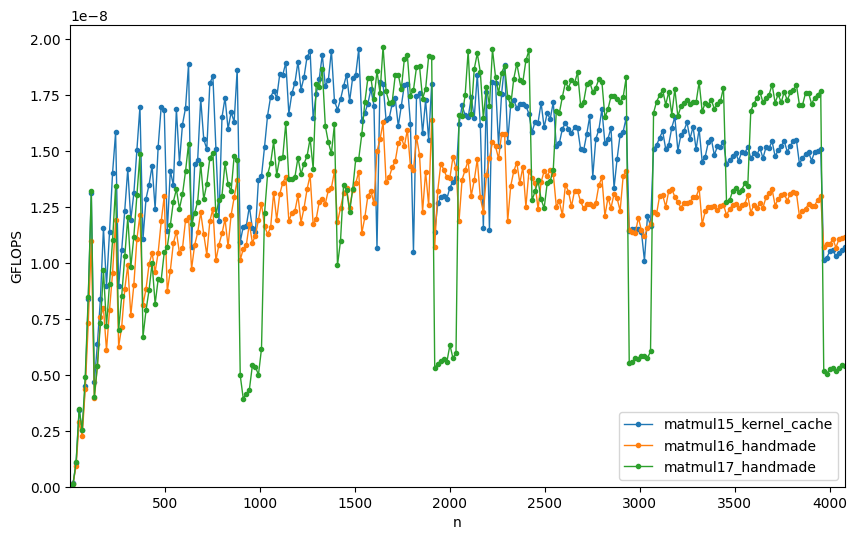

In [7]:
plot_flops(["matmul15_kernel_cache", "matmul16_handmade", "matmul17_handmade"], [n for n in range(1, 2**12+1, 16)])
# plot_flops(["matmul15_kernel_cache"], [n for n in range(1, 2**12+1, 16)])